## Scrape reports

In [1]:
from bs4 import BeautifulSoup, Comment
import requests
import pandas as pd
import numpy as np

In [4]:
base=9500
def get_page(page_id:int):
    src=requests.get(f"https://www.cenapred.unam.mx/reportesVolcanGobMX/Procesos?tipoProceso=detallesReporteVolcan&id_registro={base+page_id:04d}&caso_reporte=0")
    r=BeautifulSoup(src.text)
    return r

In [3]:
datos={}
datos["id_reporte"]=[]
datos["url"]=[]
datos["year"]=[]
datos["month"]=[]
datos["filename"]=[]
datos["ext"]=[]
datos["date"]=[]
datos["text"]=[]
last_success=0

In [95]:
import time
from fastprogress import progress_bar

page_range=9500
for p_idx in progress_bar(range(last_success,page_range)):
    try:
        page=get_page(p_idx)
        img_header="https://www.cenapred.unam.mx/popo/"
        img_count=0
        for img in page.find_all("img"):
            if img["src"][:len(img_header)]==img_header:
                folder_structure=img["src"][len(img_header):].split("/")
                folder_structure[-1]=folder_structure[-1].strip()
                try:
                    fullname=folder_structure.pop()
                    fn,ext=fullname.split(".")[:2]
                except Exception as E:
                    print(fullname)
                    raise E
                year,month=folder_structure

                datos["id_reporte"].append(p_idx+base)
                datos["url"].append(img["src"])
                datos["year"].append(year)
                datos["month"].append(month)
                datos["filename"].append(fn)
                datos["ext"].append(ext)
                datos["date"].append("EMPTY")
                datos["text"].append("EMPTY")
                img_count+=1
        comments = page.find_all(string=lambda text: isinstance(text, Comment))
        section=None
        for c in comments:
            if c=="-SECCION DE CONTENIDO-":
                section=c.parent
                break
        if section!=None:
            span=section.find_all(align="justify")[0].span
            date="EMPTY"
            try:
                date=span.b.text[:-1]
            except Exception as e:
                pass#print("WARN: ",p_idx+base,e)
            
            text=[]
            for c in span.contents:
                text.append(str(c).strip())
            text="\n".join(text)
            for i in range(img_count):
                datos["date"][-i-1]=date
                datos["text"][-i-1]=text
        last_success=p_idx+1
        #time.sleep(.25)
    except KeyboardInterrupt as e:
        print("User interruption")
        break
    #except Exception as e:
    #    print("FAIL:",p_idx+base,e)
    #    time.sleep(2)
    #if p_idx%100==0:
    #    print(f"DONE: {100*p_idx/9500:.02f}%")

In [156]:
df=pd.DataFrame(datos)
df["id_reporte"].unique().shape

(7774,)

In [157]:
df

,id_reporte,url,year,month,filename,ext,date,text
0,959,https://www.cenapred.unam.mx/popo/2000/abr/p04...,2000,abr,p0423001,jpg,"11:00 (16:00 GMT, Abril 23)","\n<b>11:00 (16:00 GMT, Abril 23):</b>\n\n<br/>..."
1,959,https://www.cenapred.unam.mx/popo/2000/abr/p04...,2000,abr,p0423002,jpg,"11:00 (16:00 GMT, Abril 23)","\n<b>11:00 (16:00 GMT, Abril 23):</b>\n\n<br/>..."
2,959,https://www.cenapred.unam.mx/popo/2000/abr/p04...,2000,abr,p0423003,jpg,"11:00 (16:00 GMT, Abril 23)","\n<b>11:00 (16:00 GMT, Abril 23):</b>\n\n<br/>..."
3,960,https://www.cenapred.unam.mx/popo/2000/abr/p04...,2000,abr,p0424001,jpg,"11:00 (16:00 GMT, Abril 24)","\n<b>11:00 (16:00 GMT, Abril 24):</b>\n\n<br/>..."
4,960,https://www.cenapred.unam.mx/popo/2000/abr/p04...,2000,abr,p0424002,jpg,"11:00 (16:00 GMT, Abril 24)","\n<b>11:00 (16:00 GMT, Abril 24):</b>\n\n<br/>..."
...,...,...,...,...,...,...,...,...
22187,9501,https://www.cenapred.unam.mx/popo/2023/mar/p03...,2023,mar,p0316234,jpeg,"Marzo 16, 11:00 h (Marzo 16, 17:00 GMT)","\n<br/>\n<b> Marzo 16, 11:00 h (Marzo 16, 17:0..."
22188,9502,https://www.cenapred.unam.mx/popo/2023/mar/p03...,2023,mar,p0317231,jpeg,"Marzo 17, 11:00 h (Marzo 17, 17:00 GMT)","\n<br/>\n<b> Marzo 17, 11:00 h (Marzo 17, 17:0..."
22189,9502,https://www.cenapred.unam.mx/popo/2023/mar/p03...,2023,mar,p0317232,jpeg,"Marzo 17, 11:00 h (Marzo 17, 17:00 GMT)","\n<br/>\n<b> Marzo 17, 11:00 h (Marzo 17, 17:0..."
22190,9502,https://www.cenapred.unam.mx/popo/2023/mar/p03...,2023,mar,p0317233,jpeg,"Marzo 17, 11:00 h (Marzo 17, 17:00 GMT)","\n<br/>\n<b> Marzo 17, 11:00 h (Marzo 17, 17:0..."


<AxesSubplot: >

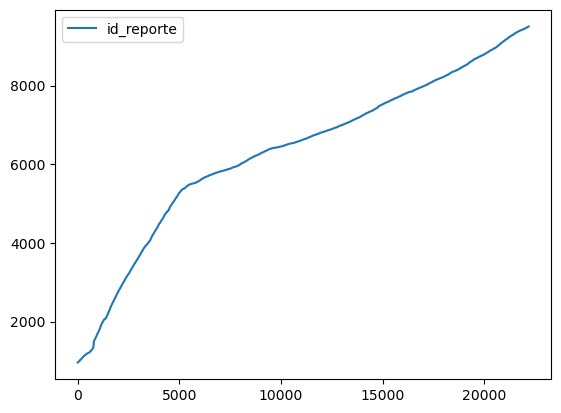

In [158]:
df[["id_reporte"]].plot()

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22192 entries, 0 to 22191
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_reporte  22192 non-null  int64 
 1   url         22192 non-null  object
 2   year        22192 non-null  object
 3   month       22192 non-null  object
 4   filename    22192 non-null  object
 5   ext         22192 non-null  object
 6   date        22192 non-null  object
 7   text        22192 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.4+ MB


In [160]:
df.to_feather("miri_raw_data.feather")

## Scrape Images

In [161]:
df=pd.read_feather("miri_raw_data.feather")

In [162]:
df.head()

,id_reporte,url,year,month,filename,ext,date,text
0,959,https://www.cenapred.unam.mx/popo/2000/abr/p04...,2000,abr,p0423001,jpg,"11:00 (16:00 GMT, Abril 23)","\n<b>11:00 (16:00 GMT, Abril 23):</b>\n\n<br/>..."
1,959,https://www.cenapred.unam.mx/popo/2000/abr/p04...,2000,abr,p0423002,jpg,"11:00 (16:00 GMT, Abril 23)","\n<b>11:00 (16:00 GMT, Abril 23):</b>\n\n<br/>..."
2,959,https://www.cenapred.unam.mx/popo/2000/abr/p04...,2000,abr,p0423003,jpg,"11:00 (16:00 GMT, Abril 23)","\n<b>11:00 (16:00 GMT, Abril 23):</b>\n\n<br/>..."
3,960,https://www.cenapred.unam.mx/popo/2000/abr/p04...,2000,abr,p0424001,jpg,"11:00 (16:00 GMT, Abril 24)","\n<b>11:00 (16:00 GMT, Abril 24):</b>\n\n<br/>..."
4,960,https://www.cenapred.unam.mx/popo/2000/abr/p04...,2000,abr,p0424002,jpg,"11:00 (16:00 GMT, Abril 24)","\n<b>11:00 (16:00 GMT, Abril 24):</b>\n\n<br/>..."


In [163]:
df[df.isnull().any(1)]

/tmp/ipykernel_66132/1040708776.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  df[df.isnull().any(1)]


,id_reporte,url,year,month,filename,ext,date,text


In [184]:
import requests
import shutil
import os

last_success=0

In [186]:
for img_idx in progress_bar(range(last_success,df.shape[0])):
    img_row=df.iloc[img_idx][["url","year","month","filename","ext"]]
    url,year,month,filename,ext=img_row
    #print(url,year,month,filename,ext)
    r = requests.get(url.strip(), stream=True)
    path=f"{year}/{month}"
    
    os.system(f"mkdir {year} > /dev/null 2>&1")
    os.system(f"mkdir {year}/{month} > /dev/null 2>&1")
    
    fullpath=path+f"/{filename}.{ext}"
    if r.status_code == 200:
        with open(fullpath, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)
    last_success=img_idx